In [1]:
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras import initializers
from keras.models import Model
from keras import backend as K
from dataGenerator import gen_train_data, test_data
from keras.callbacks import ModelCheckpoint

# ------------------------------
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [ ]:
# def identity_block(X, f, filters, stage, block):
#     """
#     Implementation of the identity block as defined in Figure 3
    
#     Arguments:
#     X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main path
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network
    
#     Returns:
#     X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
#     """
    
#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'
    
#     # Retrieve Filters
#     F1, F2, F3 = filters
    
#     # Save the input value. You'll need this later to add back to the main path. 
#     X_shortcut = X
    
#     # First component of main path
#     X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
#     X = Activation('relu')(X)

    
#     # Second component of main path (≈3 lines)
#     X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
#     X = Activation('relu')(X)

#     # Third component of main path (≈2 lines)
#     X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

#     # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
    
    
#     return X

In [ ]:
def residual_block(X, f, filters, stage, block, s):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    S1, S2, S3 = s
    
#     # Save the input value
#     X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (3, 3), strides = (S1,S1), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Save the input value
    X_shortcut = X

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (1, 1), strides = (S2,S2), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (3, 3), strides = (S3,S3), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (S2,S2), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [2]:
def SACNN(input_shape=(256, 256, 3), classes=3):
    """ Arguments: input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    Returns: model -- a Model() instance in Keras """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(8, (3, 3), strides=(1, 1), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
#     X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    ### START CODE HERE ###

    # Stage 2 (≈4 lines)
    X = residual_block(X, f = 3, filters = [16, 8, 16], stage = 2, block='RB_1', s = [2,1,1])
    
    # Stage 3 (≈6 lines)
    X = residual_block(X, f = 3, filters = [32, 16, 32], stage = 3, block='RB_2', s = [2,1,1])
    
    # Stage 4 (≈3 lines)
    X = residual_block(X, f = 3, filters = [64, 32, 64], stage = 4, block='RB_3', s = [2,1,1])
   
    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    X = Conv2D(64, (3, 3), strides = (1,1), name = 'conv11', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn11')(X)
    X = Activation('relu')(X) 
    
    X = Conv2D(128, (3, 3), strides = (1,1), name = 'conv12', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn12')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(64, (1, 1), strides = (1,1), name = 'conv13', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn13')(X)
    X = Activation('relu')(X)
    
    X = GlobalAveragePooling2D((2,2), name="global_avg_pool")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='SACNN')

    return model

In [ ]:
model = SACNN(input_shape = (256, 256, 3), classes = 3)
model.summary()


In [2]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [14]:
def ResNet50(input_shape=(224, 224, 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
#     X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
#     X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

#     # Stage 5 (≈3 lines)
#     X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
#     X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
#     X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

#     X = Conv2D(64, (3, 3), strides=(1, 1), name='conv11', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = Conv2D(128, (3, 3), strides=(2, 2), name='conv12', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = Conv2D(64, (1, 1), strides=(1, 1), name='conv13', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name='bn_conv1')(X)
#     X = Activation('relu')(X)
#     X = GlobalAveragePooling2D()(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [15]:
model = ResNet50(input_shape = (224, 224, 3), classes = 6)
model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [11]:
import pandas as pd
train_df = pd.read_csv("D:/Dataset/Plant_data_ISMAB/output/train_data.csv", index_col = None)
test_df = pd.read_csv("D:/Dataset/Plant_data_ISMAB/output/test_data.csv", index_col = None)

print(train_df.head())
print(test_df.head())

                                            FileName  Label        ClassName
0  D:/Dataset/Plant_data_ISMAB/output/train\Apple...      0  Apple_black_rot
1  D:/Dataset/Plant_data_ISMAB/output/train\Apple...      0  Apple_black_rot
2  D:/Dataset/Plant_data_ISMAB/output/train\Apple...      0  Apple_black_rot
3  D:/Dataset/Plant_data_ISMAB/output/train\Apple...      0  Apple_black_rot
4  D:/Dataset/Plant_data_ISMAB/output/train\Apple...      0  Apple_black_rot
                                            FileName  Label        ClassName
0  D:/Dataset/Plant_data_ISMAB/output/test\Apple_...      0  Apple_black_rot
1  D:/Dataset/Plant_data_ISMAB/output/test\Apple_...      0  Apple_black_rot
2  D:/Dataset/Plant_data_ISMAB/output/test\Apple_...      0  Apple_black_rot
3  D:/Dataset/Plant_data_ISMAB/output/test\Apple_...      0  Apple_black_rot
4  D:/Dataset/Plant_data_ISMAB/output/test\Apple_...      0  Apple_black_rot


In [14]:
i = 200
print(test_df['Label'][i])

4


In [18]:
i=j = 0
print(i,j)

0 0


In [20]:
import cv2
train_img = []
test_img = []
train_y = []
test_y = []
i = 0
j = 0
for f in train_df['FileName']:
    img = cv2.imread(f)
    train_img.append(img)
    train_img.append(img)
    train_y.append(train_df['Label'][i])
    i+=1
for f in test_df['FileName']:
    img = cv2.imread(f)
    test_img.append(img)
    test_y.append(test_df['Label'][j])
    j+=1

print(len(train_img))   
print(len(test_img))

4752
297


In [26]:
train_img = np.array(train_img)
print(train_img.shape)

(4752,)


In [22]:
# Normalize image vectors
import numpy as np

X_train = np.array(train_img)/255.
X_test = np.array(test_img)/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(train_y, 6).T
Y_test = convert_to_one_hot(test_y, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

AttributeError: 'list' object has no attribute 'reshape'

In [7]:
history = model.fit(X_train, Y_train, epochs = 20, batch_size = 32)


Epoch 1/20
1080/1080 [==============================] - 46s 43ms/step - loss: 1.2386 - accuracy: 0.6463
Epoch 2/20
1080/1080 [==============================] - 40s 37ms/step - loss: 0.2483 - accuracy: 0.9065
Epoch 3/20
1080/1080 [==============================] - 40s 37ms/step - loss: 0.3543 - accuracy: 0.8806
Epoch 4/20
1080/1080 [==============================] - 43s 40ms/step - loss: 0.1947 - accuracy: 0.9361
Epoch 5/20
1080/1080 [==============================] - 41s 38ms/step - loss: 0.0755 - accuracy: 0.9741
Epoch 6/20
1080/1080 [==============================] - 41s 38ms/step - loss: 0.0452 - accuracy: 0.9833
Epoch 7/20
1080/1080 [==============================] - 41s 38ms/step - loss: 0.0137 - accuracy: 0.9954
Epoch 8/20
1080/1080 [==============================] - 40s 37ms/step - loss: 0.0087 - accuracy: 0.9981
Epoch 9/20
1080/1080 [==============================] - 42s 39ms/step - loss: 0.0069 - accuracy: 0.9981
Epoch 10/20
1080/1080 [==============================] - 42s 39m

In [9]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))


120/120 [==============================] - 2s 13ms/step
Loss = 0.30020171304543813
Test Accuracy = 0.9333333373069763


Input image shape: (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[0.00731539 0.28308553 0.0053498  0.62415713 0.00869804 0.07139406]]


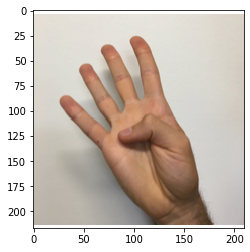

In [13]:
img_path = 'images/sign_4.png'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = image.load_img(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))